# Spatial Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon, JOIN_STYLE, Polygon, LineString
from osgeo import osr, gdal, ogr
from zonal_stats import *

import os
import gc


%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [3]:
# Move working directory to Data folder
os.chdir('/Tesis/Datos') 
os.getcwd()
pkls = '/Tesis/Codes/pkls/'

## Create file
In the file doesn't exist

In [4]:
# Read residential consumption data
ZM_out = pd.read_pickle(pkls + 'ZM_out_final.pkl')
ZM_out.rename(columns={'ageb':'CVE_AGEB','mza':'CVE_MZA'}, inplace=True)
ZM_out['CVE_MZA'] = ZM_out['CVE_MZA'].apply(lambda n:'%03d'%n)

# Read denues consumption data
denues_mnz = pd.read_pickle(pkls + 'denues_mnz.pkl')

# Read shapefile
mza = pd.read_pickle(pkls + 'mza_shp.pkl')

# Merge shp and residential consumption
loc =['CVE_ZM', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA']
mza_ele = mza.merge(ZM_out, on=loc, how='left')

# merge mza and denues
mza_ele = mza_ele.merge(denues_mnz, on=['CVE_ZM', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA'], how='left')

ZM_list = []
with open(pkls + 'ZM_list.txt', "r") as f:
    for line in f:
        ZM_list.append(line.strip())

mza_ele_ZM = mza_ele.loc[(mza_ele['CVE_ZM'].isin(ZM_list)) & (mza_ele['AMBITO']=='Urbana')].copy()
mza_ele_ZM['area'] = mza_ele_ZM['geometry'].area
mza_ele_ZM.loc[mza_ele_ZM['pobtot']==0,['tot_integ','nivelaprob','ocupados','h_m_sexo','ma_me_edad','edad']] = np.nan

mza_ele_ZM.head()

In [10]:
mza_ele_ZM.to_pickle(pkls + 'mza_ele_ZM.pkl')

## Load file
If you already have the file

In [4]:
mza_ele_ZM = pd.read_pickle(pkls + 'mza_ele_ZM.pkl')

cols = mza_ele_ZM.columns.to_list()
ZM_spatial = mza_ele_ZM[cols[:6]+cols[8:11]+['pobtot','area']+['Res_consumption_a']+cols[24:27]+['ele_TOT']].copy()
ZM_spatial.rename(columns={"Res_consumption_a":"RES", "ele_AGR":"AGR", "ele_COM":"COM", 
                           "ele_IND":"IND", 'ele_TOT':'ECO'}, inplace=True)
ZM_spatial.loc[ZM_spatial['pobtot']==0,'RES'] = 0
ZM_spatial['ele_TOTAL'] = ZM_spatial[['RES','ECO']].sum(axis=1, min_count=1)

In [8]:
ZM_spatial.groupby(['CVE_ZM','NOM_ZM','CVE_MUN']).sum()


CVE_ENT  CVE_LOC     pobtot  \
CVE_ZM NOM_ZM                  CVE_MUN                                
1.01   Aguascalientes          1001       10034   318086   734842.0   
                               1005        1014    75671    66154.0   
                               1011         275     2688    19623.0   
2.01   Ensenada                2001       18650  2161785   393291.0   
2.02   Mexicali                2002       30422  1120828   832929.0   
2.03   Tijuana                 2003        3150   220843    77115.0   
                               2004       43806  4509001  1504289.0   
                               2005        4168    34239    73805.0   
3.01   La Paz                  3003       18105    44715   222709.0   
4.01   Campeche                4002       15276    25831   224906.0   
5.01   La Laguna               5009        4555     4784    30854.0   
                               5017        7940    20122    69470.0   
                               5035       59935    58587   617923.0   
                               10007      54640    43870   266172.0   
                               10012      31100    46281   109130.0   
5.02   Monclova-Frontera       5006        3820      764    23577.0   
                               5010        6845     1561    71094.0   
                               5018       22100     4420   214735.0   
                               5031        3260      652    20443.0   
5.03   Piedras Negras          5022        6820    21964    27049.0   
                               5025       19070     3814   149843.0   
5.04   Saltillo                5004        2610      522     8370.0   
                               5027        9120     1824    65898.0   
                               5030       61860    12372   708034.0   
6.01   Colima-Villa de álvarez 6002       21048     3508   134057.0   
                               6003        1830     2719    13848.0   
                               6004        2298     1825    15809.0   
                               6005        3414     4953    18760.0   
                               6010       17082     2847   114397.0   
6.02   Tecomán                 6001        3618     4495    22482.0   
                               6009       11976    16258   102246.0   
7.01   Tapachula               7089       31612   192296   232349.0   
7.02   Tuxtla Gutiérrez        7012        4564      652    28016.0   
                               7027        7714    85558    47779.0   
                               7079        1253      179     9578.0   
                               7086        2541      363    16534.0   
                               7101       61453    22619   546336.0   
8.01   Chihuahua               8002        7856      982    18553.0   
                               8004        3080      385     7135.0   
                               8019      163368    20421   805410.0   
8.02   Delicias                8021       23744   190347   124653.0   
                               8045        7984     6122    31159.0   
8.04   Juárez                  8037      187120   155262  1318168.0   
9.01   Valle de México         9002       28980     3220   413047.0   
                               9003       43371     4819   619738.0   
                               9004        9666     2974   181718.0   
                               9005       76968     8552  1184408.0   
                               9006       26082     2898   382744.0   
                               9007      133893    14877  1802819.0   
                               9008       13023     1447   235386.0   
                               9009        9063    41972   111147.0   
                               9010       47754     5306   723154.0   
                               9011       28530    12124   354144.0   
                               9012       44838    17216   635873.0   
                               9013       25947     2883   40385

In [12]:
x = ZM_spatial.groupby(['CVE_ZM','NOM_ZM','CVE_MUN'], as_index=False).sum()
x['RES'] =x['RES']/1000000
x.loc[x['CVE_ZM']==14.01].sort_values(by=('RES'), ascending=False)

,CVE_ZM,NOM_ZM,CVE_MUN,CVE_ENT,CVE_LOC,pobtot,area,RES,AGR,COM,IND,ECO,ele_TOTAL
146,14.01,Guadalajara,14039,191058,13647,1492163.0,1.096553e+08,555.848413,166714.363890,1.109956e+09,3.292993e+09,4.403115e+09,4.958964e+09
153,14.01,Guadalajara,14120,196700,375572,1216026.0,1.660578e+08,448.840318,235757.686309,5.570155e+08,2.098302e+09,2.655554e+09,3.104394e+09
151,14.01,Guadalajara,14098,93884,17052,592462.0,6.911180e+07,197.762391,79147.223261,2.289954e+08,7.982434e+08,1.027318e+09,1.225080e+09
152,14.01,Guadalajara,14101,77448,24517,448542.0,5.305318e+07,142.597502,58939.421577,1.342061e+08,3.244080e+08,4.586730e+08,6.012705e+08
150,14.01,Guadalajara,14097,102984,3019973,362593.0,7.719855e+07,124.747140,146506.562207,1.192194e+08,5.165297e+08,6.358956e+08,7.606428e+08
149,14.01,Guadalajara,14070,43652,81017,133478.0,3.187088e+07,41.601688,0.000000,5.204146e+07,4.320452e+08,4.840867e+08,5.256884e+08
154,14.01,Guadalajara,14124,9128,14982,38156.0,9.914072e+06,12.531294,0.000000,2.260499e+07,4.691997e+07,6.952496e+07,8.205625e+07
147,14.01,Guadalajara,14044,8694,1990,23777.0,1.169101e+07,8.117407,0.000000,7.992470e+06,1.358667e+07,2.157914e+07,2.969654e+07
145,14.01,Guadalajara,14002,4438,557,20297.0,5.857819e+06,7.027810,5051.950421,8.732180e+06,2.484167e+07,3.357890e+07,4.060671e+07
148,14.01,Guadalajara,14051,2310,165,9078.0,2.534191e+06,3.154624,0.000000,3.589948e+06,6.984101e+06,1.057405e+07,1.372867e+07


### Metropolitan areas
- 8.04 Juárez
- 14.01 Guadalajara
- 20.01 Oaxaca
- 25.02 Mazatlán

## Coverage
The missing blocks might not be missing, maybe they didn't exist yet
(the CPV is from 2010, the Marco Geoestadistico is from 2019)

In [96]:
# Coverage
df_list = []
for cve in [float(a) for a in ZM_list]:
    #print(len(ZM_spatial.loc[ZM_spatial['CVE_ZM']==cve]))
    x=[(len(ZM_spatial.loc[ZM_spatial['CVE_ZM']==cve])-len(ZM_spatial.loc[(ZM_spatial['CVE_ZM']==cve)&(ZM_spatial['pobtot'].isnull())]))/len(ZM_spatial.loc[ZM_spatial['CVE_ZM']==cve]),cve,
         ZM_spatial.loc[ZM_spatial['CVE_ZM']==cve,'NOM_ZM'].unique()[0]]
    df_list.append(x)

Coverage = pd.DataFrame(df_list, columns = ['coverage' , 'cve', 'name']) 
Coverage.sort_values(by=('coverage'), ascending=False, inplace=True)
Coverage.head()

,coverage,cve,name
24,0.953241,13.02,Tula
53,0.942834,30.05,Orizaba
16,0.940658,8.04,Juárez
49,0.936287,28.03,Nuevo Laredo
48,0.933205,28.02,Matamoros


## Energy density
kWh/m2

In [737]:
# Electricity per squared meter
ZM_m2 = ZM_spatial.copy()
ZM_m2['RESpCAP'] = ZM_spatial['RES']/ZM_spatial['pobtot']
ZM_m2.loc[ZM_m2['pobtot']==0,'RESpCAP']=0
ZM_m2.loc[:,'RES':'ele_TOTAL'] = ZM_spatial.loc[:,'RES':'ele_TOTAL'].div(ZM_spatial['area'], axis=0)


In [738]:
# This function categorizes the the column into x categories, col_list is a list of the fields you want to categorize
# if you want to categorize the economic sectors all together, set eco=True
def categorize(df, col_list, x, eco=False):
    #df = dataframe.copy()
    for var in col_list:
        if eco:
            df_eco = pd.concat([df['AGR'],df['COM'],df['IND']])
            df_no_zero = df_eco[df_eco!=0]
        else:
            df_no_zero = df.loc[df[var]!=0, var].copy()
        
        conditions = [
        (df[var].isnull()),(df[var] == 0)] + \
        [(df[var]>=df_no_zero.quantile(a/x)) & (df[var]<df_no_zero.quantile((a+1)/x)) for a in range(x-1)] + \
        [df[var]>=df_no_zero.quantile((x-1)/x)
        ]       
               
        cat = [np.nan]+[a for a in range(x+1)]
        col_new_name = 'c_'+var
        df[col_new_name] = np.select(conditions, cat, default='not classified')

In [ ]:
categorize(ZM_m2,['RES'],10)

categorize(ZM_m2,['RESpCAP'],10)

categorize(ZM_m2,['AGR','COM','IND'],10,True)

categorize(ZM_m2,['ECO'],10)

In [734]:
ZM_m2.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,geometry,CVE_ZM,NOM_ZM,pobtot,area,RES,AGR,COM,IND,ECO,ele_TOTAL,RESpCAP
0,0100100010229001,1,1001,1,0229,001,"POLYGON ((2469592.842 1101420.419399997, 24695...",1.01,Aguascalientes,65.0,246889.281669,0.094170,0.000000,1.276579,0.000000,1.276579,1.370749,357.685017
1,0100100010229002,1,1001,1,0229,002,"POLYGON ((2469982.4507 1100681.889799999, 2469...",1.01,Aguascalientes,0.0,149924.015865,0.000000,0.000000,8.072529,0.416443,8.488972,8.488972,0.000000
2,0100100010229003,1,1001,1,0229,003,"POLYGON ((2470515.4199 1100233.446999999, 2470...",1.01,Aguascalientes,0.0,181107.016350,0.000000,0.000000,12.761571,0.000000,12.761571,12.761571,0.000000
3,0100100010229004,1,1001,1,0229,004,"POLYGON ((2469819.3548 1100035.602800002, 2469...",1.01,Aguascalientes,0.0,83385.297779,0.000000,0.000000,8.551600,0.000000,8.551600,8.551600,0.000000
4,0100100010229006,1,1001,1,0229,006,"POLYGON ((2469559.613200001 1101504.7204, 2469...",1.01,Aguascalientes,25.0,2379.466961,4.224738,0.000000,4.369251,24.063092,28.432343,32.657081,402.105000
5,0100100010229007,1,1001,1,0229,007,"POLYGON ((2469379.157600001 1101559.979599999,...",1.01,Aguascalientes,99.0,5742.082713,4.663655,0.000000,1.655489,0.000000,1.655489,6.319143,270.495866
6,0100100010229008,1,1001,1,0229,008,"POLYGON ((2469514.460699998 1101572.876499997,...",1.01,Aguascalientes,78.0,4825.234304,5.122898,0.000000,0.729648,0.000000,0.729648,5.852546,316.912613
7,0100100010229010,1,1001,1,0229,010,"POLYGON ((2469561.883500002 1101443.819500001,...",1.01,Aguascalientes,134.0,8328.631978,6.424853,NaN,NaN,NaN,NaN,6.424853,399.330103
8,0100100010229013,1,1001,1,0229,013,"POLYGON ((2469546.359999998 1100501.801399997,...",1.01,Aguascalientes,0.0,21369.710584,0.000000,0.000000,7.330215,0.000000,7.330215,7.330215,0.000000
9,0100100010229014,1,1001,1,0229,014,"POLYGON ((2469563.868100002 1100496.142099999,...",1.01,Aguascalientes,0.0,3044.659272,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000


## Create a shapefile
Save the cities you want, you can change the code and select any city


In [ ]:
cve = 14.01

In [466]:
# Create shp
ZM_m2.loc[ZM_m2['CVE_ZM']==cve].to_file('/Tesis/Output/Shapes/'+string(cve)'/energy_m2_10.shp')

## Simpsons evenness index

In [480]:
col = ZM_m2.columns.to_list()
ZM_cat =ZM_m2[col[:9]+col[18:]].copy()


fields = ['c_RES','c_RESpCAP'] #set se fields you want to analyze
simpson_list = []
for field in fields:
    df = ZM_cat.loc[(ZM_cat['CVE_ZM']==cve)]
    shape = gpd.GeoDataFrame(columns=['geometry'])
    for categoria in df[field].unique():
        e = MultiPolygon(list(df.loc[df[field]==categoria, 'geometry']))
        eps = 10
        fx = e.buffer(eps, 1, join_style=JOIN_STYLE.mitre).buffer(-eps, 1, join_style=JOIN_STYLE.mitre)
        polys = gpd.GeoDataFrame(columns=['geometry'])
        if type(fx)==Polygon:
            polys = polys.append({'geometry':fx},ignore_index=True)
        else:
            polys['geometry'] = [poly for poly in fx]
        polys[field] = categoria
        shape = shape.append(polys,ignore_index=True,sort=True)

    shape['area']=shape['geometry'].area
    metrics = shape.groupby(field).sum()
    metrics.drop(['nan'], axis=0, inplace=True)
    simpsons = (1-((metrics['area']/metrics['area'].sum())**2).sum())/(1-1/len(metrics))
    simpson_list.append([field,simpsons])
    del shape, metrics

simpson_df = pd.DataFrame(simpson_list) 

In [585]:
simpson_df

,0,1
0,c_RES,0.714922
1,c_RESpCAP,0.894964


## Rasters

### Categorias de consumo
Creates a raster with the cateogrized data (might be useful later)

In [7]:

# Define pixel_size and NoData value of new raster
pixel_size = 10
NoData_value = -9999

# Filename of input OGR file
vector_fn = '/Tesis/Datos/shape.shp'
# Filename of the raster Tiff that will be created
raster_fn = '/Tesis/Datos/test.tif'

# Open the data source and read in the extent
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer()

# Create the destination data source
x_min, x_max, y_min, y_max = source_layer.GetExtent()
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

target_ds = gdal.GetDriverByName('GTiff').Create(raster_fn, x_res, y_res, 1, gdal.GDT_Float32)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

target_ds.SetProjection(source_layer.GetSpatialRef().ExportToWkt())

# target_dsSRS = osr.SpatialReference()
# target_dsSRS.ImportFromEPSG(4326)
# target_ds.SetProjection(target_dsSRS.ExportToWkt())

band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)

# Rasterize
ds = gdal.RasterizeLayer(target_ds, [1], source_layer, options = ["ATTRIBUTE=cat_val"])
#ds = gdal.RasterizeLayer(target_ds, [1], source_layer, options = ["ALL_TOUCHED=TRUE", "ATTRIBUTE=cat_val"])
target_ds = None

## Consumo por m2
Create a raster with continuous values and get the consumption of concetric rings, this one is useful

In [739]:
ZM_raster = ZM_m2.copy()
ZM_raster.loc[(~ZM_raster['pobtot'].isnull())&(ZM_raster['AGR'].isnull())&(ZM_raster['COM'].isnull())&
                      (ZM_raster['IND'].isnull()),['AGR','COM','IND','ECO']] = 0

In [781]:
dic_dist ={25.02:14300,9.01:63000,8.04:30400,14.01:33600,20.01:23300}

In [862]:
# input
cve = 9.01 #metropolitan area 
fields = ['RES','AGR','COM','IND'] # sector
line = dic_dist[cve] # distance from center to desired border
dist = 2500

In [863]:
# Define number of circules
if line/dist-line//dist>=0.5:
    num_circ = -(-line//dist)
else:
    num_circ = line//dist

In [864]:
# Create circules from city center
center = gpd.read_file('\Tesis\Output\Temp metrics/'+str(cve)+'_center.shp')
zm_center = center.iloc[0,1]

list_circ = []
first = True

for radio in [(a+1)*dist for a in range(num_circ)]:
    circleGDL = zm_center.buffer(radio)
    if first:
        list_circ.append(circleGDL)
        prev_circ = circleGDL
        first = False
        continue
    dif_circ = circleGDL.difference(prev_circ)
    list_circ.append(dif_circ)
    prev_circ = circleGDL
circ0 = gpd.GeoDataFrame(columns=['geometry'])    
circ0['geometry'] = list_circ

circ0.reset_index(inplace=True)
circ0.rename(columns={'index':'cat'}, inplace=True)
circ0.crs= {'proj': 'lcc',
 'lat_1': 17.5,
 'lat_2': 29.5,
 'lat_0': 12,
 'lon_0': -102,
 'x_0': 2500000,
 'y_0': 0,
 'ellps': 'GRS80',
 'units': 'm',
 'no_defs': True}

circ0.to_file(r'\Tesis\Output\Temp metrics\circulos'+str(cve)+'.shp')

In [865]:
list_results = []
for  field in fields:
    # Create raster
    temp = ZM_raster.loc[(ZM_raster['CVE_ZM']==cve)&(~ZM_raster[field].isnull()), ['geometry',field]].copy()
    temp.to_file(r'\Tesis\Output\Temp metrics\temp.shp')

    # Define pixel_size and NoData value of new raster
    pixel_size = 10
    NoData_value = -9999

    # Filename of input OGR file
    vector_fn = r'\Tesis\Output\Temp metrics\temp.shp'
    # Filename of the raster Tiff that will be created
    raster_fn = r'\Tesis\Output\Temp metrics/'+str(cve)+'_'+field+'.tif'

    # Open the data source and read in the extent
    source_ds = ogr.Open(vector_fn)
    source_layer = source_ds.GetLayer()

    # Create the destination data source
    x_min, x_max, y_min, y_max = source_layer.GetExtent()
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)

    target_ds = gdal.GetDriverByName('GTiff').Create(raster_fn, x_res, y_res, 1, gdal.GDT_Float32)
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

    target_ds.SetProjection(source_layer.GetSpatialRef().ExportToWkt())

    # target_dsSRS = osr.SpatialReference()
    # target_dsSRS.ImportFromEPSG(4326)
    # target_ds.SetProjection(target_dsSRS.ExportToWkt())

    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)

    # Rasterize
    ds = gdal.RasterizeLayer(target_ds, [1], source_layer, options = ["ATTRIBUTE="+field])
    #ds = gdal.RasterizeLayer(target_ds, [1], source_layer, options = ["ALL_TOUCHED=TRUE", "ATTRIBUTE=cat_val"])
    target_ds = None

    # clip circules to raster extent to avoid crash of zonal stats
    from osgeo import gdal
    import subprocess

    # define file paths
    inRasterPath = r'\Tesis\Output\Temp metrics/'+str(cve)+'_'+field+'.tif'
    inVectorPath = r'\Tesis\Output\Temp metrics\circulos'+str(cve)+'.shp'

    # get the extent of the raster
    src = gdal.Open(inRasterPath)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    sizeX = src.RasterXSize * xres
    sizeY = src.RasterYSize * yres
    lrx = ulx + sizeX
    lry = uly + sizeY
    src = None

    xmin, xmax, ymin, ymax = ulx+10, lrx-10, uly-10, lry+10 
    bounds = Polygon( [(xmin,ymin), (xmin, ymax), (xmax, ymax), (xmax,ymin)] )

    # Crop all polygons and take the part inside the bounding box
    circ0['geometry'] = circ0['geometry'].intersection(bounds)

    # Export non-empty geometries to shp
    circ0 = circ0[circ0.geometry.area>0]#.to_file("countries_CROPPED.shp", driver='ESRI Shapefile')
    circ0.to_file(r'\Tesis\Output\Temp metrics\circulos1.shp')

    # zonal stats
    vector_path = r'\Tesis\Output\Temp metrics\circulos1.shp'
    raster_path = r'\Tesis\Output\Temp metrics/'+str(cve)+'_'+field+'.tif'

    results = (pd.DataFrame.from_dict(zonal_stats(vector_path, raster_path, 'population', 'cat', nodata_value=-9999)))
    results['kwhm2_'+field] = results['sum']/results['count']

    list_results.append(results)
    print(field)

RES
AGR
COM
IND


In [868]:
metric_circ = pd.DataFrame()
metric_circ['Circule'] = list_results[0]['cat']
metric_circ['RES'] = list_results[0]['kwhm2_RES']
metric_circ['AGR'] = list_results[1]['kwhm2_AGR']
metric_circ['COM'] = list_results[2]['kwhm2_COM']
metric_circ['IND'] = list_results[3]['kwhm2_IND']
metric_circ['Built-up'] = list_results[0]['count']*100/circ0['geometry'].area

metric_circ

,Circule,RES,AGR,COM,IND,Built-up
0,0,9.058466,0.000014,65.179856,45.944557,0.717313
1,1,8.598166,0.000019,33.463352,37.557367,0.704771
2,2,6.180348,0.000040,24.806439,33.936514,0.757725
3,3,5.673325,0.000007,18.819789,31.408550,0.754799
4,4,5.434954,0.000015,8.429685,27.269337,0.702593
5,5,5.436450,0.000006,7.504863,18.972127,0.659982
6,6,4.495806,0.000006,6.581666,10.160791,0.593437
7,7,3.933567,0.000046,4.626143,10.299399,0.442887
8,8,2.835934,0.000018,2.684135,7.859610,0.423974
9,9,2.858872,0.000049,2.203187,6.063851,0.364226


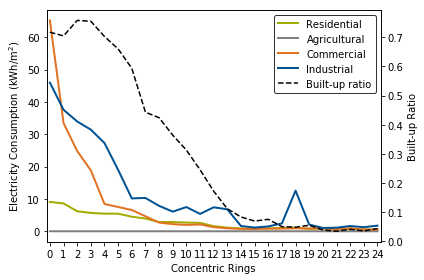

In [869]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)
p1 = ax.plot(metric_circ['Circule'], metric_circ['RES'], color="#A2AD00", linewidth=2)  
p2 = ax.plot(metric_circ['Circule'], metric_circ['AGR'], color="grey", linewidth=2)
p3 = ax.plot(metric_circ['Circule'], metric_circ['COM'], color="#E37222", linewidth=2)
p4 = ax.plot(metric_circ['Circule'], metric_circ['IND'], color="#005293", linewidth=2)


# we also need to switch the labels
ax.set_xlabel('Concentric Rings')
ax.set_ylabel(r'Electricity Consumption (kWh/m$^2$)')#'Electricity Consumption (kWh/m)'

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Built-up Ratio')  # we already handled the x-label with ax1
p5 = ax2.plot(metric_circ['Circule'], metric_circ['Built-up'], '--', color='black')
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Residential', 'Agricultural', 'Commercial', 'Industrial', 'Built-up ratio'), loc=0, frameon=True, edgecolor='black')
plt.margins(x=0.01) #0.005
#ax.grid()

#plt.savefig(r'D:\Tesis\tum-ei-ens-thesis-bundle-2018-05\thesis-latex\img\python\spatial\circles_901.eps', format='eps', bbox_inches='tight')
plt.show()  